# Hyperparameter Tuning:

The process of optimizing a model’s configurable parameters to improve its performance and generalization on unseen data.


**Dataset:** Breast Cancer dataset (from scikit-learn) 

**Models:** Support Vector Machine (SVM) classifier (linear and RBF kernels) and Random Forest 

**Goal:** To explore and compare hyperparameter tuning strategies — Grid Search, Randomized Search, and Optuna — and evaluate their impact on model performance, efficiency, and generalization.


In [1]:
#! pip install optuna


In [1]:
# ============================================================
# NOTEBOOK 2 — Hyperparameter Tuning
# Models : RandomForest, SVM
# Methods : GridSearchCV, RandomizedSearchCV, Optuna
# ============================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import optuna
#from optuna.integration import SklearnPipelineSampler

import warnings
warnings.filterwarnings("ignore")

data = load_breast_cancer()
X = data.data
y = data.target


1. Baseline model

In [2]:
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC())
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

pipe_svm.fit(X_train, y_train)
pipe_svm.score(X_test, y_test)


0.9790209790209791

2. GridSearchCV sur SVM

In [3]:
grid_params = {
    "model__C": [0.1, 1, 10],
    "model__gamma": ["scale", "auto"],
    "model__kernel": ["rbf", "linear"]
}

grid = GridSearchCV(pipe_svm, grid_params, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Test accuracy:", grid.score(X_test, y_test))


Best parameters: {'model__C': 0.1, 'model__gamma': 'scale', 'model__kernel': 'linear'}
Test accuracy: 0.986013986013986


3. RandomizedSearchCV

In [4]:
rand_params = {
    "model__C": [0.1, 1, 10],
    "model__gamma": ["scale", "auto"],
    "model__kernel": ["rbf", "linear"]
}

rand = RandomizedSearchCV(
    pipe_svm, rand_params, n_iter=25, cv=5, n_jobs=-1, random_state=42)
rand.fit(X_train, y_train)

print("Best parameters:", rand.best_params_)
print("Test accuracy:", rand.score(X_test, y_test))

Best parameters: {'model__kernel': 'linear', 'model__gamma': 'scale', 'model__C': 0.1}
Test accuracy: 0.986013986013986


4. Tuning avec OPTUNA (optimisation bayésienne)

In [5]:
def objective(trial):
    C = trial.suggest_loguniform("model__C", 1e-3, 1e3)
    gamma = trial.suggest_loguniform("model__gamma", 1e-4, 1)
    kernel = trial.suggest_categorical("model__kernel", ["rbf", "linear"])

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(C=C, gamma=gamma, kernel=kernel))
    ])

    pipe.fit(X_train, y_train)
    return pipe.score(X_test, y_test)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

study.best_params


[I 2026-01-17 11:20:09,577] A new study created in memory with name: no-name-f8847268-57b4-4716-b5b1-d2e9f2237c34
[I 2026-01-17 11:20:09,614] Trial 0 finished with value: 0.958041958041958 and parameters: {'model__C': 13.351543019105222, 'model__gamma': 0.19789088381994654, 'model__kernel': 'rbf'}. Best is trial 0 with value: 0.958041958041958.
[I 2026-01-17 11:20:09,631] Trial 1 finished with value: 0.986013986013986 and parameters: {'model__C': 0.03987344984847646, 'model__gamma': 0.4618362619848951, 'model__kernel': 'linear'}. Best is trial 1 with value: 0.986013986013986.
[I 2026-01-17 11:20:09,654] Trial 2 finished with value: 0.9440559440559441 and parameters: {'model__C': 0.0011881191307226834, 'model__gamma': 0.03733715631336282, 'model__kernel': 'linear'}. Best is trial 1 with value: 0.986013986013986.
[I 2026-01-17 11:20:09,690] Trial 3 finished with value: 0.6293706293706294 and parameters: {'model__C': 0.0013182195275435096, 'model__gamma': 0.01910545512843121, 'model__kern

{'model__C': 0.03987344984847646,
 'model__gamma': 0.4618362619848951,
 'model__kernel': 'linear'}

- On définit les hyperparams directement dans trial.suggest_*.

In [6]:

def objective(trial):

    C = trial.suggest_float("C", 1e-3, 1e3, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 1, log=True)
    kernel = trial.suggest_categorical("kernel", ["rbf", "linear"])

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(C=C, gamma=gamma, kernel=kernel))
    ])

    pipe.fit(X_train, y_train)
    return pipe.score(X_test, y_test)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

study.best_params


[I 2026-01-17 11:20:24,094] A new study created in memory with name: no-name-d20b4d48-ed8f-4589-a308-1515437f1cc5
[I 2026-01-17 11:20:24,112] Trial 0 finished with value: 0.9790209790209791 and parameters: {'C': 1.3771213313680366, 'gamma': 0.001945001394842378, 'kernel': 'linear'}. Best is trial 0 with value: 0.9790209790209791.
[I 2026-01-17 11:20:24,129] Trial 1 finished with value: 0.986013986013986 and parameters: {'C': 3.8296848120982343, 'gamma': 0.009832689838707807, 'kernel': 'rbf'}. Best is trial 1 with value: 0.986013986013986.
[I 2026-01-17 11:20:24,150] Trial 2 finished with value: 0.951048951048951 and parameters: {'C': 62.712807722970894, 'gamma': 0.04471979603383519, 'kernel': 'rbf'}. Best is trial 1 with value: 0.986013986013986.
[I 2026-01-17 11:20:24,194] Trial 3 finished with value: 0.7342657342657343 and parameters: {'C': 0.23353625586249271, 'gamma': 0.00035464818661686936, 'kernel': 'rbf'}. Best is trial 1 with value: 0.986013986013986.
[I 2026-01-17 11:20:24,214

{'C': 3.8296848120982343, 'gamma': 0.009832689838707807, 'kernel': 'rbf'}

### Question : Allez plus loin

1. Tuner un RandomForest :
      - n_estimators
      - max_depth
      - min_samples_split



In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)


Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
Best CV score: 0.9624076607387142


2️. Compare the performance of Grid vs Random vs Optuna.

    Grid Search: only for small datasets or few hyperparameters.

    Random Search: Good for quick experiments or large but not overly complex spaces.

    Optuna: Best choice for practical, large-scale hyperparameter tuning, combining efficiency and accuracy.




3️. Test Optuna with 200 trees.

In [8]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import optuna
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load Breast Cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Split dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define Optuna objective function for Random Forest
def objective(trial):
    n_estimators = 200  # Fixed number of trees
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )
    
    # Evaluate using 5-fold cross-validation
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Create Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Adjust n_trials for more thorough search

# Print best hyperparameters and CV accuracy
print("Best parameters:", study.best_params)
print("Best CV accuracy:", study.best_value)



[I 2026-01-17 11:25:00,244] A new study created in memory with name: no-name-213e80e7-de70-45b5-a816-34f8a5c4765c
[I 2026-01-17 11:25:04,404] Trial 0 finished with value: 0.9472527472527472 and parameters: {'max_depth': 2, 'min_samples_split': 3}. Best is trial 0 with value: 0.9472527472527472.
[I 2026-01-17 11:25:08,536] Trial 1 finished with value: 0.9494505494505496 and parameters: {'max_depth': 4, 'min_samples_split': 5}. Best is trial 1 with value: 0.9494505494505496.
[I 2026-01-17 11:25:12,909] Trial 2 finished with value: 0.9538461538461538 and parameters: {'max_depth': 10, 'min_samples_split': 5}. Best is trial 2 with value: 0.9538461538461538.
[I 2026-01-17 11:25:17,304] Trial 3 finished with value: 0.9516483516483518 and parameters: {'max_depth': 15, 'min_samples_split': 8}. Best is trial 2 with value: 0.9538461538461538.
[I 2026-01-17 11:25:21,881] Trial 4 finished with value: 0.9560439560439562 and parameters: {'max_depth': 6, 'min_samples_split': 2}. Best is trial 4 with v

Best parameters: {'max_depth': 13, 'min_samples_split': 2}
Best CV accuracy: 0.9604395604395606


4️. Visualize the Optuna convergence curve.

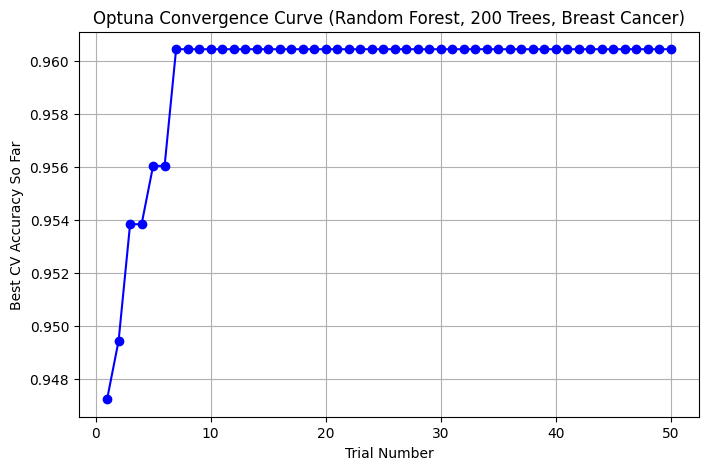

In [ ]:

# Extract the trial values (CV accuracy for each trial)
best_values = [trial.value for trial in study.trials]

# Compute cumulative best (max so far) for a smoother convergence curve
cumulative_best = []
max_so_far = -float('inf')
for v in best_values:
    max_so_far = max(max_so_far, v)
    cumulative_best.append(max_so_far)

# Plot convergence
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_best)+1), cumulative_best, marker='o', linestyle='-', color='blue')
plt.xlabel("Trial Number")
plt.ylabel("Best CV Accuracy So Far")
plt.title("Optuna Convergence Curve (Random Forest, 200 Trees, Breast Cancer)")
plt.grid(True)
plt.show()
